In [1]:
# import libraries
from tensorflow import keras
import sklearn
import mysql.connector
from mysql.connector import Error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [2]:
import tensorflow as tf
import os
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,f1_score

# Database Connection

In [3]:
class DB_Conn:
    def __init__(self):
        self.connection = None
        self.__host_name = "localhost"
        self.__username = "root"
        self.__pw="Root@123"  # SQL Terminal Password ####  ### Class Attributes
        self.db="ACP_detection"  # Databse Name #####
    
    def set_credentials(self, username, password, database):
        self.username = username
        self.pw = password
        self.db = database
        
    def create_server_connection(self):
        try:
            connection= mysql.connector.connect(
                host=self.__host_name,
                user=self.__username,
                password=self.__pw
            )
            print("Server connection successful")
        except Error as err:
            print(f"Error: '{err}'")
        return connection
    
    def create_db_connection(self):
        connection= None
        try:
            connection= mysql.connector.connect(
                host=self.__host_name,
                user=self.__username,
                password=self.__pw,
                database= self.db)
            print("Database connection successful")
        except Error as err:
            print(f"Error: '{err}'" )
        return connection

# Database Creation using Query

In [4]:
class DB_Manager:
    def __init__(self):
        self.db_create_query= "Create database ACP_detection" ### Database creation Query
    
    def get_db_name(self, db_name):
        self.db_create_query = "Create database " + db_name
    
    def create_database(self, connection):
        cursor= connection.cursor()
        try:
            cursor.execute(self.db_create_query)
            print("Database created successfully")
        except Error as err:
            print(f"Error: '{err}'" )
    
    def execute_query(self,connection,query):
        cursor= connection.cursor()
        try:
            cursor.execute(query)
            result = cursor.fetchall()
            connection.commit()
            print("Query was successful")
        except Error as err:
            print(f"Error: '{err}'" )
        return result
    
    def load_data(self, connection, data):
        cur= connection.cursor()
        s= "INSERT INTO samples (Peptide_sequence, label) VALUES (%s,%s)"
        cur.executemany(s, data)
        connection.commit()
        print("Data Loaded Successfully")

# Accessing Database using Objects

In [5]:
DBC = DB_Conn()

In [6]:
server_connection = DBC.create_server_connection()

Server connection successful


In [7]:
DBM = DB_Manager()
DBM.create_database(server_connection)

Database created successfully


In [8]:
db_connection = DBC.create_db_connection()

Database connection successful


In [9]:
# Creating Table in the database to store Sample records.
create_table= """
create table samples(
Peptide_sequence varchar(200),
label int);
"""
#connect to the database
DBM.execute_query(db_connection,create_table)

Query was successful


[]

# Reading Fasta files

In [10]:
# Reading the input Fasta File

#Negative samples
with open(r'C:\Users\mailt\Desktop\fasta\fasta\data\negative\balanced.fasta','r') as a:
    x = a.read()
    
#Positive Samples
with open(r'C:\Users\mailt\Desktop\fasta\fasta\data\positive\balanced.fasta','r') as e:
    u= e.read()


# Data Pre processing 

In [11]:
# Data Pre processing 

class Data_Preprocessor:
    def __init__(self):
        pass
    
    def preprocess(self, data, cls): 
        s= data.split("\n")
        n= len(s)

        arr=[]
        while n>0:
            arr.append(s[n-2])
            n= n-2
        
        lst=[]
        for i in range(len(arr)-1):
            lst1=[]
            a=()   
            lst1.append(arr[i])
            lst1.append(cls)
            a= tuple(lst1)
            lst.append(a)

        return lst

In [12]:
preprocessor = Data_Preprocessor()
lst = preprocessor.preprocess(x, 0)
lst1 = preprocessor.preprocess(u, 1)


# Loading Samples in SQL Table

In [13]:
DBM.load_data(db_connection, lst)         ## Negative Samples
DBM.load_data(db_connection, lst1)        ##Positive Samples


Data Loaded Successfully
Data Loaded Successfully


In [14]:
# calling all the samples from database.
q1="""
select * from samples;
"""
results=DBM.execute_query(db_connection, q1)

Query was successful


In [15]:
# Converting the data to a dataframe.

#create data frame 

df=[]

for res in results:
    result= list(res)
    df.append(res)
    
columns= ["Peptide_sequence", "label"]
df= pd.DataFrame(df,columns=columns )

display(df)

,Peptide_sequence,label
0,YSPGRTARADLRKASSTFSPPSPYSPPNSRPLSSPLDELASLFNSGR,0
1,YSPETNYMLMLLCVGV,0
2,YSMEGVNHAAAVSGEVKGHYLNATAATMEDMYERAEFAK,0
3,YSGDDAYATDAILNS,0
4,YSDEQVE,0
...,...,...
445,AIGSILGALAKGLPTLISWIKNR,1
446,ACYCRIPACIAGERRYGTCIYQGRLWAFCC,1
447,ACSAG,1
448,AAPTATVTPSSGLSDGTVVKVAGAGLQAGTAYDVGQCAWVDTGVLA...,1


In [17]:
# Loading the p-feature analysis file

d2=pd.read_csv(r"C:\Users\mailt\Desktop\OOPD project\only_dipeptid (1).csv")
d2.head()
pf = d2.reindex(np.random.permutation(d2.index))


In [18]:
#Preprocessing the file using Standard Scaler
sc=StandardScaler()
c2=pd.DataFrame(sc.fit_transform(pf))
c2.columns=pf.columns
c2.head()


,ID,DPC1_AA,DPC1_AC,DPC1_AD,DPC1_AE,DPC1_AF,DPC1_AG,DPC1_AH,DPC1_AI,DPC1_AK,...,DPC1_YN,DPC1_YP,DPC1_YQ,DPC1_YR,DPC1_YS,DPC1_YT,DPC1_YV,DPC1_YW,DPC1_YY,Label
0,1.481869,-0.370771,-0.147173,-0.211785,-0.343457,-0.211008,-0.329097,-0.180736,-0.375497,-0.309228,...,-0.15927,-0.177785,-0.150662,-0.189071,-0.173675,-0.176058,-0.155311,-0.130292,-0.075198,-1.0
1,0.765953,-0.370771,-0.147173,-0.211785,-0.343457,-0.211008,-0.329097,-0.180736,-0.375497,-0.309228,...,-0.15927,-0.177785,-0.150662,-0.189071,-0.173675,7.614837,-0.155311,-0.130292,-0.075198,-1.0
2,1.197043,-0.370771,-0.147173,-0.211785,-0.343457,-0.211008,-0.329097,-0.180736,-0.375497,-0.309228,...,-0.15927,-0.177785,-0.150662,-0.189071,-0.173675,-0.176058,-0.155311,-0.130292,-0.075198,-1.0
3,0.796745,1.191804,-0.147173,-0.211785,-0.343457,-0.211008,-0.329097,-0.180736,-0.375497,-0.309228,...,-0.15927,-0.177785,-0.150662,-0.189071,-0.173675,-0.176058,-0.155311,-0.130292,-0.075198,-1.0
4,-1.150854,-0.370771,-0.147173,-0.211785,-0.343457,-0.211008,-0.329097,-0.180736,-0.375497,-0.309228,...,-0.15927,-0.177785,-0.150662,-0.189071,-0.173675,-0.176058,-0.155311,-0.130292,-0.075198,1.0


In [19]:
Y1=c2.Label

# Feature Selection using Variance Threshold

In [20]:
vt=VarianceThreshold(1.0)
fs=vt.fit_transform(c2)
fs=c2.columns[vt.get_support(indices=True)]
c3=c2[fs]
c3.head()


,DPC1_AG,DPC1_AK,DPC1_AM,DPC1_AN,DPC1_AR,DPC1_AW,DPC1_CC,DPC1_CD,DPC1_CI,DPC1_CN,...,DPC1_WY,DPC1_YF,DPC1_YG,DPC1_YH,DPC1_YM,DPC1_YN,DPC1_YP,DPC1_YQ,DPC1_YS,DPC1_YV
0,-0.329097,-0.309228,-0.145043,-0.245414,-0.234633,-0.134341,-0.169572,-0.142779,-0.205505,-0.127356,...,-0.081752,-0.140551,-0.184672,-0.047193,-0.085658,-0.15927,-0.177785,-0.150662,-0.173675,-0.155311
1,-0.329097,-0.309228,-0.145043,-0.245414,-0.234633,-0.134341,-0.169572,-0.142779,-0.205505,-0.127356,...,-0.081752,5.813713,-0.184672,-0.047193,-0.085658,-0.15927,-0.177785,-0.150662,-0.173675,-0.155311
2,-0.329097,-0.309228,-0.145043,-0.245414,-0.234633,-0.134341,-0.169572,-0.142779,-0.205505,-0.127356,...,-0.081752,-0.140551,-0.184672,-0.047193,-0.085658,-0.15927,-0.177785,-0.150662,-0.173675,-0.155311
3,-0.329097,-0.309228,1.962586,6.437134,-0.234633,-0.134341,-0.169572,-0.142779,-0.205505,-0.127356,...,-0.081752,-0.140551,-0.184672,-0.047193,-0.085658,-0.15927,-0.177785,-0.150662,-0.173675,-0.155311
4,-0.329097,-0.309228,-0.145043,-0.245414,-0.234633,-0.134341,-0.169572,-0.142779,-0.205505,-0.127356,...,-0.081752,-0.140551,-0.184672,-0.047193,-0.085658,-0.15927,-0.177785,-0.150662,-0.173675,-0.155311


In [21]:
# Removing NA values and calculating the mean of dataframe and replacing NA with mean.
m=round(c3.mean(),6)
m
c3.fillna(m,inplace=True)
c3.head(5)

c:\users\mailt\appdata\local\programs\python\python37\lib\site-packages\pandas\core\generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


,DPC1_AG,DPC1_AK,DPC1_AM,DPC1_AN,DPC1_AR,DPC1_AW,DPC1_CC,DPC1_CD,DPC1_CI,DPC1_CN,...,DPC1_WY,DPC1_YF,DPC1_YG,DPC1_YH,DPC1_YM,DPC1_YN,DPC1_YP,DPC1_YQ,DPC1_YS,DPC1_YV
0,-0.329097,-0.309228,-0.145043,-0.245414,-0.234633,-0.134341,-0.169572,-0.142779,-0.205505,-0.127356,...,-0.081752,-0.140551,-0.184672,-0.047193,-0.085658,-0.15927,-0.177785,-0.150662,-0.173675,-0.155311
1,-0.329097,-0.309228,-0.145043,-0.245414,-0.234633,-0.134341,-0.169572,-0.142779,-0.205505,-0.127356,...,-0.081752,5.813713,-0.184672,-0.047193,-0.085658,-0.15927,-0.177785,-0.150662,-0.173675,-0.155311
2,-0.329097,-0.309228,-0.145043,-0.245414,-0.234633,-0.134341,-0.169572,-0.142779,-0.205505,-0.127356,...,-0.081752,-0.140551,-0.184672,-0.047193,-0.085658,-0.15927,-0.177785,-0.150662,-0.173675,-0.155311
3,-0.329097,-0.309228,1.962586,6.437134,-0.234633,-0.134341,-0.169572,-0.142779,-0.205505,-0.127356,...,-0.081752,-0.140551,-0.184672,-0.047193,-0.085658,-0.15927,-0.177785,-0.150662,-0.173675,-0.155311
4,-0.329097,-0.309228,-0.145043,-0.245414,-0.234633,-0.134341,-0.169572,-0.142779,-0.205505,-0.127356,...,-0.081752,-0.140551,-0.184672,-0.047193,-0.085658,-0.15927,-0.177785,-0.150662,-0.173675,-0.155311


In [22]:
# Splitting the Dataset usinig train_test_split with training size = 70% and Testing size= 30%
X_train, X_test, Y_train, Y_test = train_test_split(c3, Y1, test_size=0.30, random_state= 22) 

# Decision Tree Classifier

In [114]:
class DecisionTreeClassifierModel:
    def __init__(self):
        self.Model=None
        self.prediction_dt= None
        self.predictt=None
        self.accuracy= 0
        self.f1score= 0
        
    def fit(self,X_train, Y_train):
        self.Model= DecisionTreeClassifier(random_state=15)
        self.Model= self.Model.fit(X_train,Y_train)
        
        return self.Model
    
    def predict_values(self, X_test):
        self.prediction_dt= self.Model
        self.prediction_dt = self.prediction_dt.predict(X_test)
        arr=[]
        for i in self.prediction_dt:
            if i <0:
                arr.append(0)
            else:
                arr.append(1)
        
        return arr
    
    def predict(self,X_test):
        self.predictt= self.Model.predict(X_test)        
        
        return self.predictt 
    
    def accuracy(self,Y_test):
        arr1=[]
        acc= accuracy_score(self.predictt,Y_test)
        f1score= f1_score(self.predictt,Y_test)
        arr1.append(acc)
        arr1.append(f1score)
        return arr1
        

In [115]:
DTC= DecisionTreeClassifierModel()
aa=DTC.fit(X_train, Y_train)
aa

DecisionTreeClassifier(random_state=15)

In [116]:
aa1= DTC.predict_values(X_test)
aa1

In [120]:
predict= DTC.predict(X_test)
acc1= (accuracy_score(predict,Y_test))
print("Accuracy of Decision Tree: ",acc1)
fs1= (f1_score(predict,Y_test))
print("f1_score of Decision Tree: ",fs1)

Accuracy of Decision Tree:  0.7703703703703704
f1_score of Decision Tree:  0.7559055118110236


# Random Forest Classifier

In [131]:
class RandomForestModel:
    def __init__(self):
        self.Model=None
        self.prediction_dt= None
        self.predictt=None
        self.accuracy= 0
        self.f1score= 0
        
    def fit(self,X_train, Y_train):
        self.Model= RandomForestClassifier(random_state=18) #max_depth=2,max_features='auto',n_estimators=3,
        self.Model= self.Model.fit(X_train,Y_train)
        
        return self.Model
    
    def Random(self,X_train, Y_train):
        
        return self.Model.score(X_train,Y_train)
    
    def predict_values(self, X_test):
        self.prediction_dt= self.Model
        self.prediction_dt = self.prediction_dt.predict(X_test)
        arr=[]
        for i in self.prediction_dt:
            if i <0:
                arr.append(0)
            else:
                arr.append(1)
        
        return arr
    
    
    def probability(self,X_test):
        return self.Model.predict_proba(X_test)[:,1]
    
    
    def predict(self,X_test):
        self.predictt= self.Model.predict(X_test)        
        
        return self.predictt 
    
    def accuracy(self,Y_test):
        arr1=[]
        acc= accuracy_score(self.predictt,Y_test)
        f1score= f1_score(self.predictt,Y_test)
        arr1.append(acc)
        arr1.append(f1score)
        return arr1
        

In [132]:
RFM=RandomForestModel()

In [133]:
RF=RFM.fit(X_train, Y_train)
RF

RandomForestClassifier(random_state=18)

In [134]:
RFM.Random(X_train,Y_train)

1.0

In [136]:
# Predicting value in form of 0 and 1.
RFM.predict_values(X_test)

[1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1]

In [137]:
#Predicting the Probability Values
RFM.probability(X_test)

array([0.99, 0.28, 0.92, 0.43, 0.36, 0.33, 0.99, 0.94, 0.56, 0.57, 0.89,
       0.34, 0.45, 0.23, 0.23, 0.94, 0.44, 0.49, 0.1 , 0.74, 0.44, 0.46,
       0.59, 0.86, 0.68, 0.18, 0.59, 0.13, 0.39, 0.17, 0.4 , 0.65, 0.11,
       0.35, 0.26, 0.97, 0.3 , 0.39, 0.53, 0.36, 0.62, 0.6 , 0.88, 0.78,
       0.1 , 0.24, 0.75, 0.53, 0.56, 0.57, 0.15, 0.68, 0.52, 0.49, 0.07,
       0.93, 1.  , 0.13, 0.22, 0.82, 0.73, 0.88, 0.59, 0.96, 0.79, 0.5 ,
       0.95, 0.15, 0.93, 0.55, 0.49, 0.4 , 0.65, 0.16, 0.53, 0.65, 0.93,
       0.54, 0.52, 0.57, 0.23, 0.5 , 0.09, 0.6 , 0.5 , 0.66, 0.27, 0.52,
       0.61, 0.15, 0.45, 0.27, 0.42, 0.98, 0.46, 0.78, 0.44, 0.79, 0.97,
       0.5 , 0.92, 0.25, 0.72, 0.97, 0.17, 1.  , 0.39, 0.15, 0.94, 0.67,
       0.29, 0.34, 0.44, 0.71, 0.7 , 0.24, 0.39, 0.42, 0.35, 0.85, 0.32,
       0.27, 0.53, 0.94, 0.58, 0.28, 0.13, 0.13, 0.21, 0.59, 0.63, 0.39,
       0.67, 0.96, 0.91])

In [138]:
# Calculating the accuracy svcore of our Model.
predict1= RFM.predict(X_test)
accRF= (accuracy_score(predict1,Y_test))
print("Accuracy of Random Forest: ",accRF)

# Calculating the f1 Score of Our Random Forest Model.
f1RF= (f1_score(predict,Y_test))
print("f1_score of Random Forest: ",f1RF)

Accuracy of Random Forest:  0.8074074074074075
f1_score of Random Forest:  0.7559055118110236


confusion matrix
[[58 18]
 [ 8 51]]


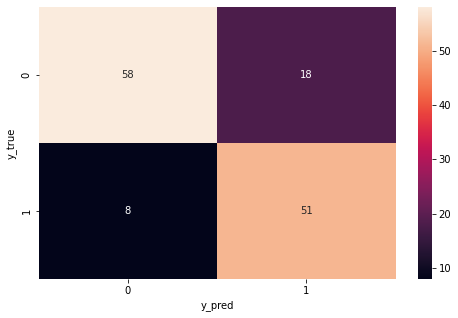

In [31]:
# Plotting a Confusion Matrix of Our result.

print('Confusion matrix')
print(confusion_matrix(Y_test, prediction_RF))
    #confusion matrix
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(Y_test, prediction_RF), annot=True, fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [32]:
# calculating the fpr and tpr values.
y_pred_keras = Y_test_pred_proba.ravel()
y_test_kears= Y_test.ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test_kears, y_pred_keras)

In [33]:
# Calculating the auc score of our RF Model.
auc_keras = auc(fpr_keras, tpr_keras)
print(auc_keras)

0.9025423728813559


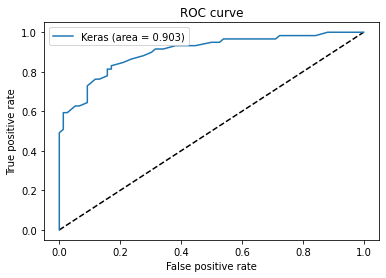

In [34]:
# Plotting the ROC curve

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [140]:
class Conf_metrix:
    # Creating a function to report confusion metrics
    def confusion_metrics (self,conf_matrix):
    # save confusion matrix and slice into four pieces
        TP = conf_matrix[1][1]
        TN = conf_matrix[0][0]
        FP = conf_matrix[0][1]
        FN = conf_matrix[1][0]
        print('True Positives:', TP)
        print('True Negatives:', TN)
        print('False Positives:', FP)
        print('False Negatives:', FN)
    
    # calculate accuracy
        conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
    
    # calculate mis-classification
        conf_misclassification = 1- conf_accuracy
    
    # calculate the sensitivity
        conf_sensitivity = (TP / float(TP + FN))
    # calculate the specificity
        conf_specificity = (TN / float(TN + FP))
    
        # calculate precision
        conf_precision = (TN / float(TN + FP))
        # calculate f_1 score
        conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))
        print('-'*50)
        print(f'Accuracy: {round(conf_accuracy,2)}') 
        print(f'Mis-Classification: {round(conf_misclassification,2)}') 
        print(f'Sensitivity: {round(conf_sensitivity,2)}') 
        print(f'Specificity: {round(conf_specificity,2)}') 
        print(f'Precision: {round(conf_precision,2)}')
        print(f'f_1 Score: {round(conf_f1,2)}')

In [141]:
mat= Conf_metrix()
res=confusion_matrix(Y_test, prediction_RF)
mat.confusion_metrics(res)

True Positives: 51
True Negatives: 58
False Positives: 18
False Negatives: 8
--------------------------------------------------
Accuracy: 0.81
Mis-Classification: 0.19
Sensitivity: 0.86
Specificity: 0.76
Precision: 0.76
f_1 Score: 0.81


# Saving the values to the database

In [37]:
create_table= """
create table Results(
Peptide_sequence varchar(200),
label int);
"""
#connect to the database
DBM.execute_query(db_connection,create_table)

Query was successful


[]

In [38]:
# processing the final Data before loading in the database.
preprocessor = Data_Preprocessor()
aY = [1 if i == 1 else 0 for i in prediction_RF]
testindex=X_test.index

lst3=[]
for i in range(len(aY)):
    lst2=[]
    a=()
    b= testindex[i]
    lst2.append(df.Peptide_sequence[b])
    lst2.append(aY[i])
    a= tuple(lst2)
    lst3.append(a)

### 

In [40]:
class DB_Load:
    def __init__(self):
        pass
    
    def load_data1(self, connection, data):
        cur= connection.cursor()
        s= "INSERT INTO results (Peptide_sequence, label) VALUES (%s,%s)"
        cur.executemany(s, data)
        connection.commit()
        print("Data Loaded Successfully")

In [41]:
load= DB_Load()
load.load_data1(db_connection,lst3)

Data Loaded Successfully
